# Teleportation

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

In [2]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    

#
# See below for when to use this
#
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)
        

In [4]:
  
    
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)



# Create random 1-qubit state
psi = random_state(1)
# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)
init_gate = Initialize(psi)
init_gate.label = "init"

qc.s(0)
qc.h(0)
qc.y(0)
qc.rz(np.pi/4, 0)

## STEP 0
# First, let's initialize Alice's q0
# qc.append(init_gate, [0])
qc.barrier()

<IPython.core.display.Math object>

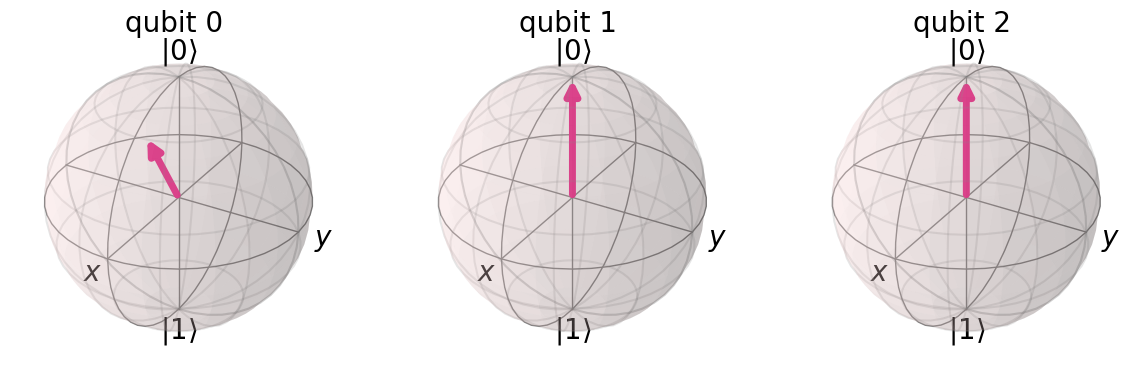

In [5]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

In [6]:
## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob 
# measure_and_send(qc, 0, 1)                        

Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00  →  Do nothing
01  →  Apply $X$ gate
10  →  Apply $Z$  gate
11  →  Apply  $ZX$  gate

(Note that this transfer of information is purely classical.)

In [7]:
## STEP 4
# Bob decodes qubits
#bob_gates(qc, 2, crz, crx)                         
# new_bob_gates(qc, 0, 1, 2)                           # WHEN QUANTUM

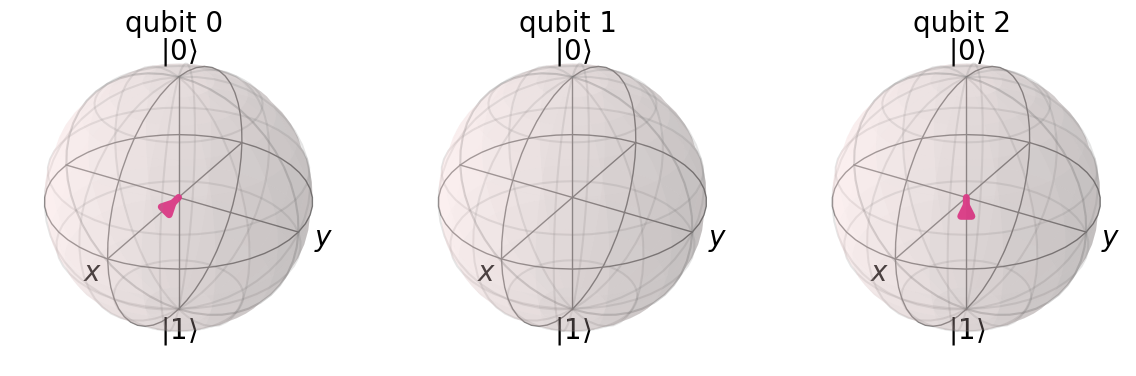

In [8]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

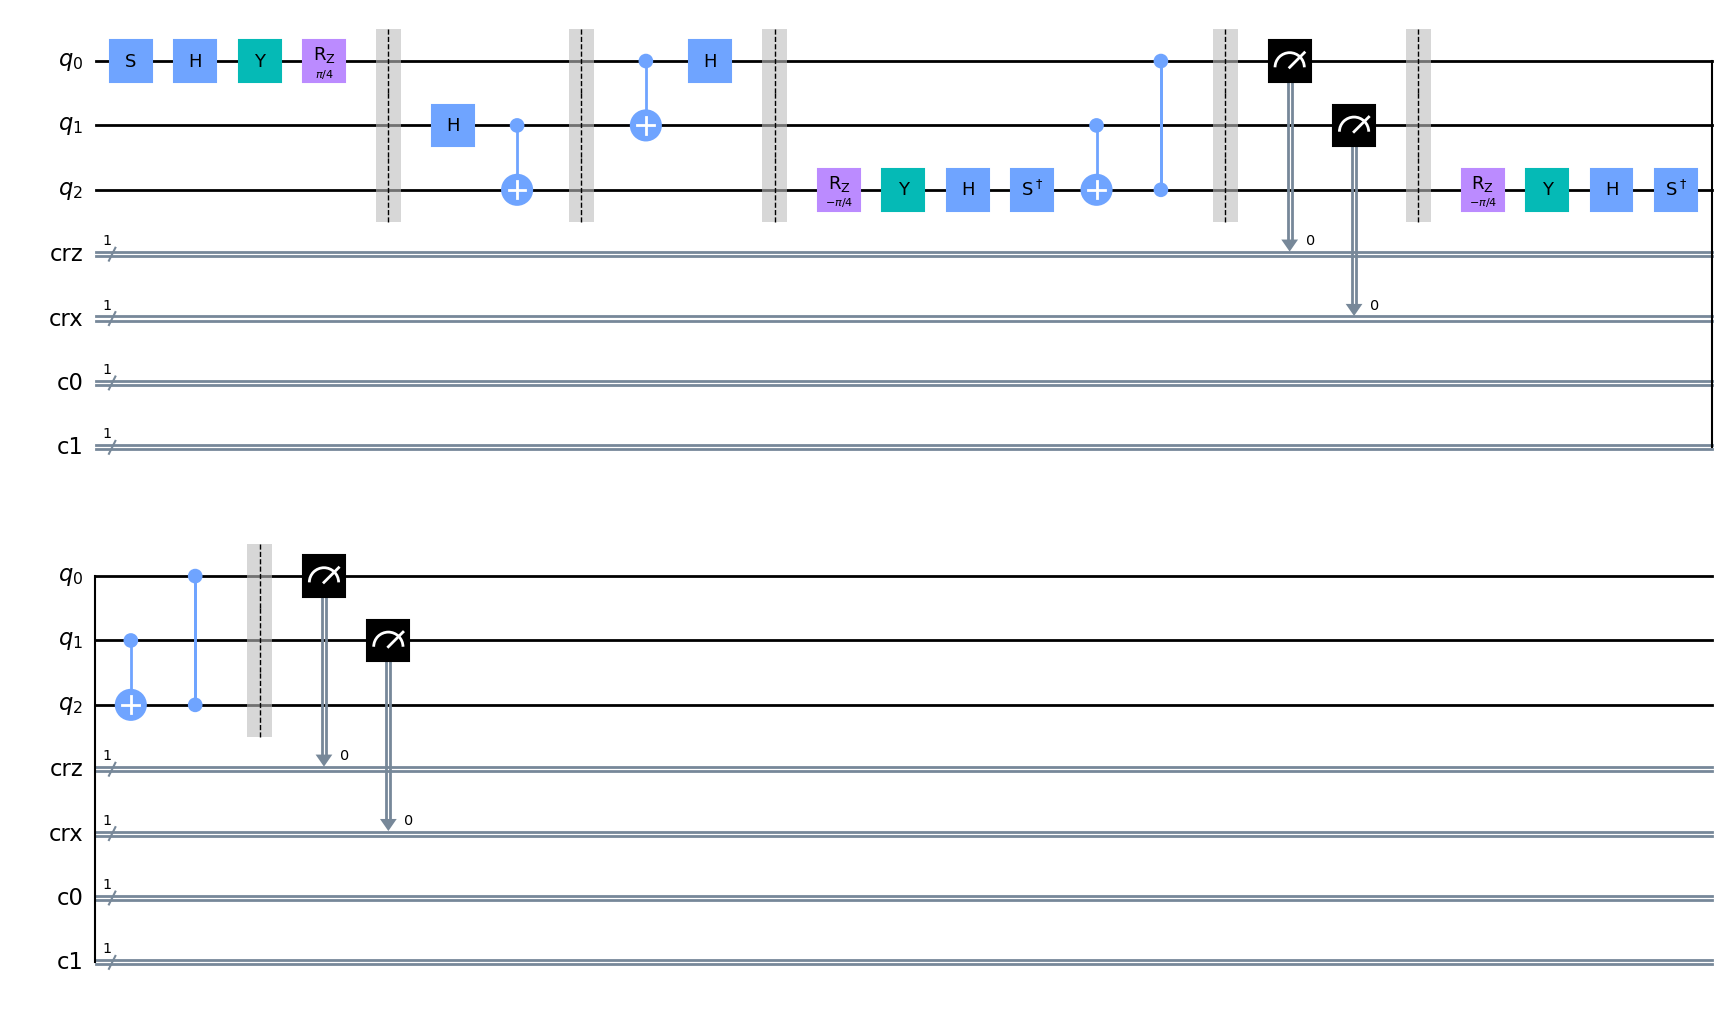

In [16]:
## STEP 5
# reverse the initialization process
# inverse_init_gate = init_gate.gates_to_uncompute()
# qc.append(inverse_init_gate, [2])qc.s(0)
qc.barrier()

qc.rz(-np.pi/4, 2)
qc.y(2)
qc.h(2)
qc.sdg(2)

new_bob_gates(qc, 0, 1, 2) 
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)     
qc.add_register(cr_result)           
measure_and_send(qc, 0, 1)


qc.draw(output='mpl', filename = 'shors.png')

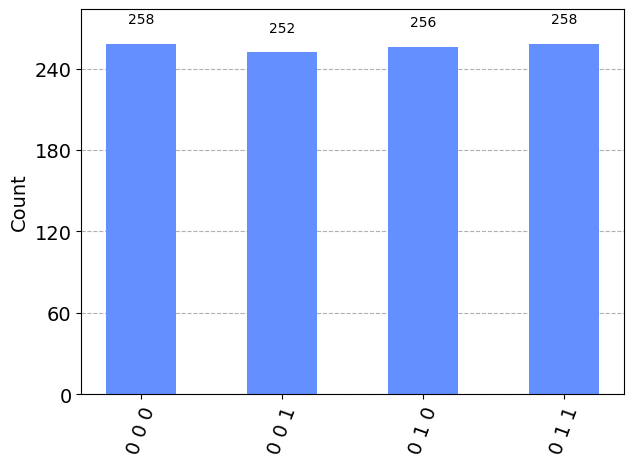

In [10]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring  $q_2$ (the leftmost bit in the string) in the state |0⟩. This is the expected result, and indicates the teleportation protocol has worked properly.

<H4>IBM hardware and Deferred Measurement</H4>

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the "deferred measurement principle". The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.
<img src="resources/deferredMeasurement.PNG">

So we can replace the bob_gates with: 

<pre>
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)
</pre>

# NEED TO FIX THE PROGRAM TO RUN IT ON A Quantum Computer

<img src="resources/HW_version.PNG">

In [11]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [12]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
print("least busy backend: ", backend)

#shots=1024
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

least busy backend:  ibmq_belem


/var/folders/rr/ydryh0913_q6_r11vnv6jl9m0000gn/T/ipykernel_7304/3170653343.py:11: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


{'0 0 0': 252, '0 0 1': 228, '0 1 0': 258, '0 1 1': 286}


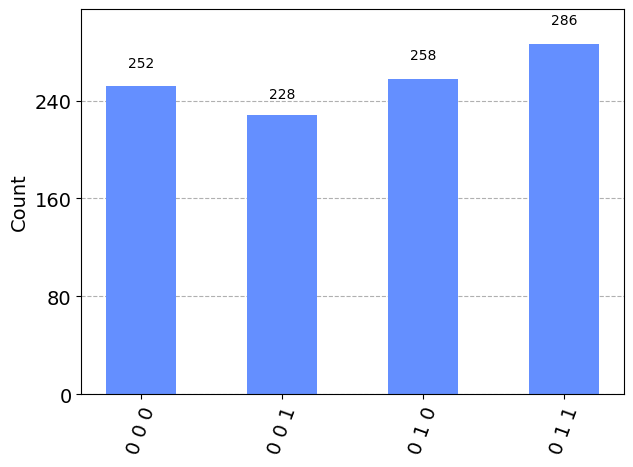

In [13]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [14]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

KeyError: '1'